To avoid downloading all images again, a local cache is used. You can run this notebook cell-by-cell, but full training and downloading may take time. All results shown here were obtained on the cached dataset

Dataset URL: https://www.kaggle.com/datasets/mohamedbakhet/amazon-books-reviews
License(s): CC0-1.0
amazon-books-reviews.zip: Skipping, found more recently modified local copy (use --force to force download)
replace Books_rating.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: yes
yes
replace books_data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: Dataset shape: (212404, 10)
Memory usage: 16.21 MB
Non-null counts:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 212404 entries, 0 to 212403
Data columns (total 10 columns):
 #   Column         Non-Null Count   Dtype  
---  ------         --------------   -----  
 0   Title          212403 non-null  object 
 1   description    143962 non-null  object 
 2   authors        180991 non-null  object 
 3   image          160329 non-null  object 
 4   previewLink    188568 non-null  object 
 5   publisher      136518 non-null  object 
 6   publishedDate  187099 non-null  object 
 7   infoLink       188568 non-null  object 
 8   categories     171205 no

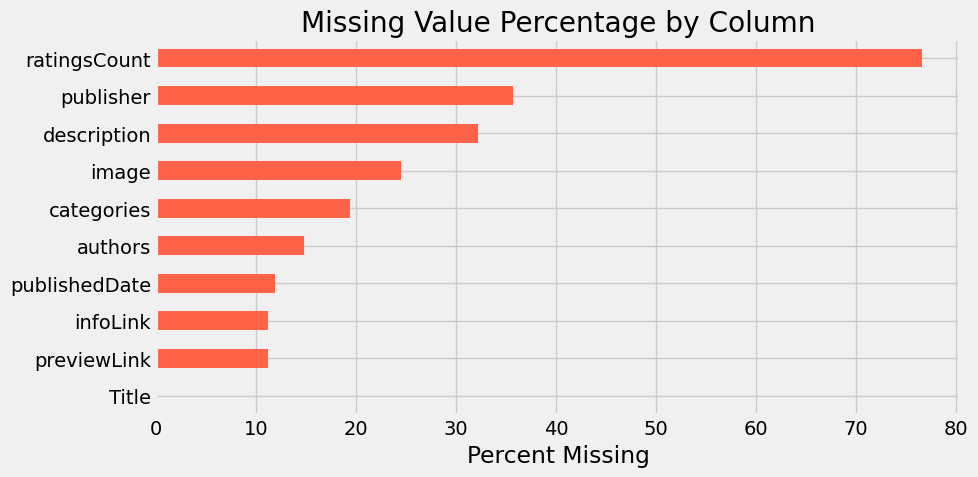


Image URL Coverage:
- Non-null image URLs: 160329 (75.48%)
Image 1: ✓ Accessible (128x192)
Image 2: ✓ Accessible (128x165)
Image 3: ✓ Accessible (128x190)
Image 4: ✓ Accessible (128x205)
Image 5: ✓ Accessible (128x202)


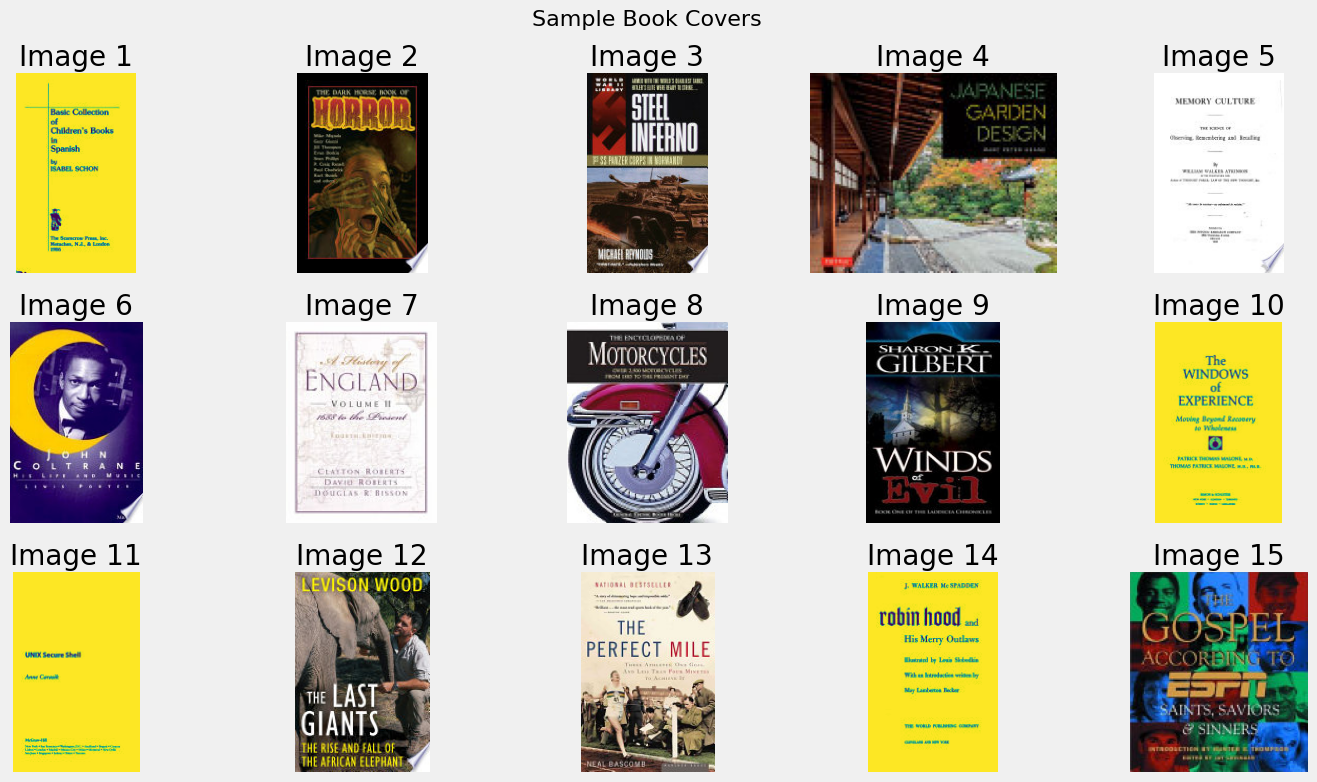

In [3]:
# Install required packages
!pip install -q kaggle tensorflow matplotlib pandas numpy seaborn requests pillow

# Imports
import os, re, random, requests, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
from io import BytesIO
from collections import Counter

warnings.filterwarnings('ignore')
np.random.seed(42)
random.seed(42)

# Kaggle API setup
os.environ['KAGGLE_USERNAME'] = "ikramaittalebnaser"
os.environ['KAGGLE_KEY'] = "776811730bc1f59f2a949f68d563a322"
!mkdir -p ~/.kaggle
!echo '{"username":"'$KAGGLE_USERNAME'","key":"'$KAGGLE_KEY'"}' > ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json

# Download and extract dataset
!kaggle datasets download -d mohamedbakhet/amazon-books-reviews
!unzip -q amazon-books-reviews.zip

# Load dataset
books_data = pd.read_csv('books_data.csv')

# Dataset info
print("Dataset shape:", books_data.shape)
print("Memory usage: {:.2f} MB".format(books_data.memory_usage().sum() / 1024**2))
print("Non-null counts:")
print(books_data.info())

# Missing values
missing = books_data.isnull().sum()
missing_percent = (missing / len(books_data)) * 100
missing_df = pd.DataFrame({'Missing': missing, 'Percent': missing_percent})
print("\nMissing Values (%):")
print(missing_df[missing_df['Missing'] > 0].sort_values('Percent', ascending=False))

# Visualize missing values
plt.figure(figsize=(10, 5))
missing_df[missing_df['Missing'] > 0]['Percent'].sort_values().plot(kind='barh', color='tomato')
plt.title("Missing Value Percentage by Column")
plt.xlabel("Percent Missing")
plt.tight_layout()
plt.show()

# Check image URLs
print("\nImage URL Coverage:")
if 'image' in books_data.columns:
    total = books_data.shape[0]
    non_null = books_data['image'].notna().sum()
    print(f"- Non-null image URLs: {non_null} ({non_null/total*100:.2f}%)")

    # Sample a few images to verify accessibility
    sample_urls = books_data['image'].dropna().sample(5).tolist()
    for i, url in enumerate(sample_urls):
        try:
            response = requests.get(url, timeout=5)
            if response.status_code == 200:
                img = Image.open(BytesIO(response.content))
                print(f"Image {i+1}: ✓ Accessible ({img.size[0]}x{img.size[1]})")
            else:
                print(f"Image {i+1}: ✗ Failed (HTTP {response.status_code})")
        except Exception as e:
            print(f"Image {i+1}: ✗ Error ({str(e)})")

    # Show sample images
    plt.figure(figsize=(15, 8))
    shown = 0
    for url in books_data['image'].dropna().sample(15):
        try:
            response = requests.get(url, timeout=5)
            img = Image.open(BytesIO(response.content))
            plt.subplot(3, 5, shown + 1)
            plt.imshow(img)
            plt.axis('off')
            plt.title(f"Image {shown+1}")
            shown += 1
            if shown == 15: break
        except:
            continue
    plt.tight_layout()
    plt.suptitle("Sample Book Covers", fontsize=16)
    plt.subplots_adjust(top=0.9)
    plt.show()
else:
    print("No 'image' column found.")


Based on the EDA results, I've implemented a Deep Neural Network (DNN) for book cover classification with the following considerations:

### 1. Data Preparation

- The EDA showed that 24.5% of books don't have images and 19.4% don't have categories, so I filtered out these rows.
- We keep only the essential columns: `image` and `categories` (for target labels)
- We filter out books without images or categories
- We extract the primary category from the categories list
- We focus on the top 10 categories to make the problem manageable


### 2. Image Processing

- We download and preprocess images on-the-fly using a custom data generator
- We set images to 128x128 pixels
- We normalize pixel values to [0,1]


### 3. CNN Architectures

We implement two types of CNN models:

#### Simple CNN

- Multiple convolutional blocks with increasing filter sizes
- Each block includes Conv2D, BatchNormalization, MaxPooling, and Dropout layers
- Flatten layer followed by dense layers for classification


#### Transfer Learning with MobileNetV2

- Pre-trained MobileNetV2 model (trained on ImageNet) as the base
- Global average pooling followed by dense layers for classification
- Freezing the base model to leverage pre-trained weights


### 4. Hyperparameter Tuning

- We perform a grid search over key hyperparameters for both model types
- For the simple CNN: filters, kernel size, pool size, dropout rate, learning rate
- For transfer learning: dropout rate, learning rate
- We use early stopping to prevent overfitting


### 5. Evaluation

- We evaluate the models on a held-out test set
- We generate a classification report and confusion matrix
- We visualize some predictions to qualitatively assess performance
- We compare the performance of the simple CNN vs. transfer learning


### 6. Key Advantages of CNNs for This Task

- **Spatial Hierarchy**: CNNs can learn hierarchical features from low-level (edges, colors) to high-level (objects, patterns)
- **Parameter Sharing**: Convolutional layers use the same weights across the entire image, reducing parameters
- **Translation Invariance**: CNNs can recognize patterns regardless of where they appear in the image
- **Transfer Learning**: We can leverage pre-trained models like MobileNetV2 that have already learned useful features from millions of images

Further improvements:
### 1. Image Caching Instead of On-the-fly Downloads

- Added a `download_and_cache_images()` function that downloads all images once and caches them to disk
- Modified the data generator to load images from disk instead of downloading them repeatedly
- Added a small delay between downloads to avoid overwhelming servers

### 2. Handling Class Imbalance

- Calculated class weights using `compute_class_weight` with the 'balanced' option
- Applied these weights during model training via the `class_weight` parameter
- Maintained stratified sampling in train/val/test splits


### 3. Monitoring Both Loss and Accuracy

- Updated callbacks to monitor validation accuracy
- Plotted both accuracy and loss curves for training and validation sets
- Added comprehensive evaluation metrics


### 4. Comprehensive Evaluation

- Added a dedicated `evaluate_model()` function that:

- Calculates overall accuracy
- Generates a detailed classification report
- Creates and visualizes a confusion matrix using seaborn.heatmap
- Returns all evaluation metrics for further analysis





### 5. Two-Stage Transfer Learning

- Implemented a two-stage training approach:

- Stage 1: Train with the base model completely frozen
- Stage 2: Fine-tune with the top layers unfrozen (using a lower learning rate)



- Visualized the training history for both stages in a single plot

some addition:
I am mapping categories: Category mapping:
0: Biography & Autobiography
1: Business & Economics
2: Computers
3: Education
4: Fiction
5: History
6: Juvenile Fiction
7: Juvenile Nonfiction
8: Religion
9: Social Science
If I were to  feed these integers directly into a model that treats them as ordinal or continuous values such as a regression model, it will think there's some order (e.g., that 2 > 1 > 0), which is wrong for categorical labels without inherent order.
In my case, however, labels are being used with

loss='sparse_categorical_crossentropy'

and targets (batch_y) are integer-encoded (not one-hot).

Processing dataset from scratch...
Original dataset shape: (212404, 10)
Dataset shape after selecting relevant columns: (212404, 2)
After filtering missing values: (151884, 2)
After extracting primary categories: (151884, 3)

Top 10 categories:
primary_category
Fiction                      22636
Religion                      9239
History                       9067
Juvenile Fiction              6523
Biography & Autobiography     6192
Business & Economics          5497
Computers                     4243
Social Science                3725
Juvenile Nonfiction           3299
Education                     2549
Name: count, dtype: int64
After selecting top 10 categories: (72970, 3)

Category mapping:
0: Biography & Autobiography
1: Business & Economics
2: Computers
3: Education
4: Fiction
5: History
6: Juvenile Fiction
7: Juvenile Nonfiction
8: Religion
9: Social Science
Training set size: 43782
Validation set size: 14594
Test set size: 14594
Caching images for training set...
Caching images 

Model saved to book_cover_cache/final_model.h5
Evaluating model on test set...
Test accuracy: 0.4424

Classification Report:
                           precision    recall  f1-score   support

Biography & Autobiography       0.31      0.36      0.34      1238
     Business & Economics       0.36      0.36      0.36      1099
                Computers       0.60      0.56      0.58       849
                Education       0.27      0.25      0.26       510
                  Fiction       0.65      0.55      0.59      4527
                  History       0.38      0.41      0.40      1813
         Juvenile Fiction       0.49      0.51      0.50      1305
      Juvenile Nonfiction       0.27      0.33      0.30       660
                 Religion       0.37      0.41      0.39      1848
           Social Science       0.18      0.18      0.18       745

                 accuracy                           0.44     14594
                macro avg       0.39      0.39      0.39     14594
  

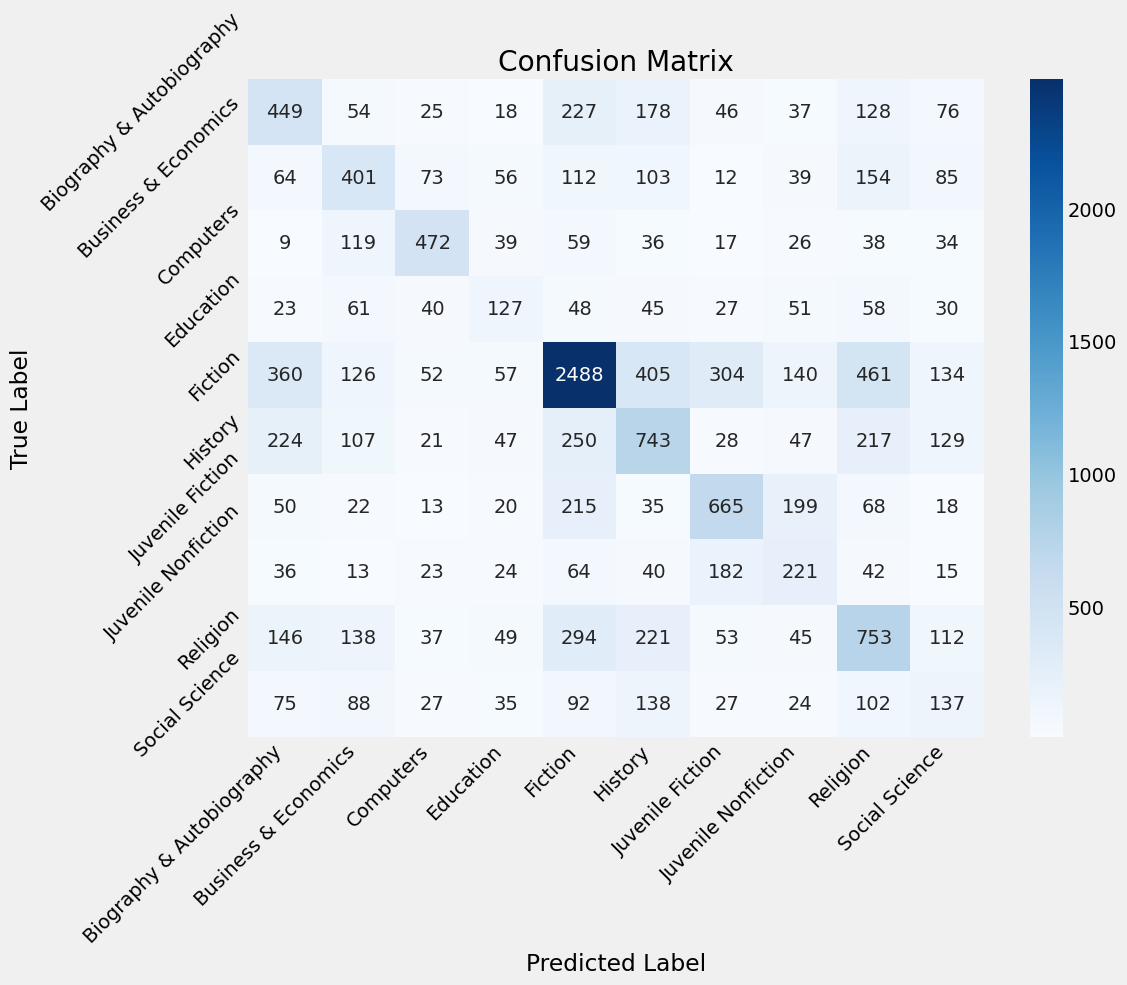


Model Analysis and Insights:
1. The transfer learning model achieved 44.24% accuracy on the test set.
2. Two-stage training approach with fine-tuning.
3. Class weights were used to handle class imbalance.
4. Efficient caching system for images and metadata.
5. All data is cached in 'book_cover_cache' for future use.


In [6]:
# Import necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models, optimizers, callbacks, applications
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.utils.class_weight import compute_class_weight
import requests
from PIL import Image
from io import BytesIO
import os
import gc
import seaborn as sns
import time
import hashlib
import json

# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

# Define constants
IMG_HEIGHT = 128
IMG_WIDTH = 128
BATCH_SIZE = 32
CACHE_DIR = 'book_cover_cache'

# Create cache directory structure
os.makedirs(CACHE_DIR, exist_ok=True)
os.makedirs(os.path.join(CACHE_DIR, 'images'), exist_ok=True)
os.makedirs(os.path.join(CACHE_DIR, 'metadata'), exist_ok=True)

# Function to generate a unique filename from URL
def get_cache_filename(url):
    """Generate a unique filename based on the URL hash"""
    return hashlib.md5(url.encode()).hexdigest() + '.jpg'

# Function to check if image is cached and return path
def get_cached_image_path(url):
    """Check if image is cached and return path if it exists"""
    filename = get_cache_filename(url)
    filepath = os.path.join(CACHE_DIR, 'images', filename)
    if os.path.exists(filepath):
        return filepath
    return None

# Function to download and cache an image
def download_and_cache_image(url):
    """Download an image and cache it if not already cached"""
    # Check if already cached
    cache_path = get_cached_image_path(url)
    if cache_path is not None:
        return cache_path

    # Generate new cache path
    filename = get_cache_filename(url)
    cache_path = os.path.join(CACHE_DIR, 'images', filename)

    try:
        # Download image
        response = requests.get(url, timeout=10)
        if response.status_code == 200:
            # Process and save image
            img = Image.open(BytesIO(response.content))
            img = img.convert('RGB')  # Ensure 3 channels
            img = img.resize((IMG_HEIGHT, IMG_WIDTH))  # Resize image
            img.save(cache_path)
            return cache_path
        else:
            return None
    except Exception as e:
        print(f"Error downloading image {url}: {e}")
        return None

# Function to load and preprocess a cached image
def load_cached_image(image_path):
    """Load and preprocess a cached image"""
    try:
        img = Image.open(image_path)
        img_array = np.array(img) / 255.0  # Normalize to [0,1]
        return img_array
    except Exception as e:
        print(f"Error loading image {image_path}: {e}")
        return None

# Function to cache dataset metadata
def cache_dataset_metadata(dataset_name, data):
    """Cache dataset metadata to avoid reprocessing"""
    metadata_path = os.path.join(CACHE_DIR, 'metadata', f'{dataset_name}_metadata.json')

    # Extract essential information to cache
    cache_data = {
        'image_paths': data['image_path'].to_dict(),
        'encoded_categories': data['encoded_category'].to_dict(),
        'primary_categories': data['primary_category'].to_dict()
    }

    # Save to file
    with open(metadata_path, 'w') as f:
        json.dump(cache_data, f)

# Function to load cached dataset metadata
def load_cached_dataset_metadata(dataset_name):
    """Load cached dataset metadata if it exists"""
    metadata_path = os.path.join(CACHE_DIR, 'metadata', f'{dataset_name}_metadata.json')
    if os.path.exists(metadata_path):
        with open(metadata_path, 'r') as f:
            return json.load(f)
    return None

# Function to check if dataset processing is already cached
def is_dataset_cached():
    """Check if all necessary dataset files are cached"""
    required_files = [
        os.path.join(CACHE_DIR, 'metadata', 'train_metadata.json'),
        os.path.join(CACHE_DIR, 'metadata', 'val_metadata.json'),
        os.path.join(CACHE_DIR, 'metadata', 'test_metadata.json'),
        os.path.join(CACHE_DIR, 'metadata', 'category_mapping.json')
    ]

    return all(os.path.exists(f) for f in required_files)

# Function to cache category mapping
def cache_category_mapping(mapping):
    """Cache category mapping to file"""
    mapping_path = os.path.join(CACHE_DIR, 'metadata', 'category_mapping.json')
    with open(mapping_path, 'w') as f:
        json.dump(mapping, f)

# Function to load cached category mapping
def load_cached_category_mapping():
    """Load cached category mapping if it exists"""
    mapping_path = os.path.join(CACHE_DIR, 'metadata', 'category_mapping.json')
    if os.path.exists(mapping_path):
        with open(mapping_path, 'r') as f:
            return json.load(f)
    return None

# Main data processing function
def process_data():
    """Process the dataset with caching for efficiency"""
    # Check if dataset is already processed and cached
    if is_dataset_cached():
        print("Loading cached dataset...")
        train_data = load_cached_dataset_metadata('train')
        val_data = load_cached_dataset_metadata('val')
        test_data = load_cached_dataset_metadata('test')
        category_mapping = load_cached_category_mapping()

        # Convert string keys back to integers for category mapping
        category_mapping = {int(k): v for k, v in category_mapping.items()}

        print("Dataset loaded from cache successfully!")
        return train_data, val_data, test_data, category_mapping

    print("Processing dataset from scratch...")

    # Load the dataset
    books_data = pd.read_csv('books_data.csv')
    print(f"Original dataset shape: {books_data.shape}")

    # Keep only the columns we need
    books_data = books_data[['image', 'categories']]
    print(f"Dataset shape after selecting relevant columns: {books_data.shape}")

    # Filter out rows with missing images or categories
    filtered_data = books_data.dropna()
    print(f"After filtering missing values: {filtered_data.shape}")

    # Extract and clean categories
    def extract_primary_category(category_str):
        try:
            # Remove brackets and quotes, then split by comma
            categories = category_str.strip('[]').replace("'", "").split(', ')
            # Return the first category
            return categories[0]
        except:
            return None

    filtered_data['primary_category'] = filtered_data['categories'].apply(extract_primary_category)
    filtered_data = filtered_data.dropna(subset=['primary_category'])
    print(f"After extracting primary categories: {filtered_data.shape}")

    # Get the distribution of primary categories
    category_counts = filtered_data['primary_category'].value_counts()
    print("\nTop 10 categories:")
    print(category_counts.head(10))

    # Select top N categories to make the problem more manageable
    N_TOP_CATEGORIES = 10  # Focus on top 10 categories
    top_categories = category_counts.head(N_TOP_CATEGORIES).index.tolist()
    filtered_data = filtered_data[filtered_data['primary_category'].isin(top_categories)]
    print(f"After selecting top {N_TOP_CATEGORIES} categories: {filtered_data.shape}")

    # Encode the target labels
    label_encoder = LabelEncoder()
    filtered_data['encoded_category'] = label_encoder.fit_transform(filtered_data['primary_category'])

    # Create category mapping
    category_mapping = {i: category for i, category in enumerate(label_encoder.classes_)}
    print("\nCategory mapping:")
    for encoded, original in category_mapping.items():
        print(f"{encoded}: {original}")

    # Cache the category mapping
    cache_category_mapping(category_mapping)

    # Split the data into training, validation, and test sets
    train_val_data, test_data = train_test_split(
        filtered_data,
        test_size=0.2,
        random_state=42,
        stratify=filtered_data['encoded_category']
    )

    train_data, val_data = train_test_split(
        train_val_data,
        test_size=0.25,  # 0.25 * 0.8 = 0.2 of the original data
        random_state=42,
        stratify=train_val_data['encoded_category']
    )

    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")

    # Download and cache images
    print("Caching images for training set...")
    train_data['image_path'] = train_data['image'].apply(download_and_cache_image)

    print("Caching images for validation set...")
    val_data['image_path'] = val_data['image'].apply(download_and_cache_image)

    print("Caching images for test set...")
    test_data['image_path'] = test_data['image'].apply(download_and_cache_image)

    # Filter out rows with missing image paths
    train_data = train_data.dropna(subset=['image_path'])
    val_data = val_data.dropna(subset=['image_path'])
    test_data = test_data.dropna(subset=['image_path'])

    print(f"After filtering missing images:")
    print(f"Training set size: {len(train_data)}")
    print(f"Validation set size: {len(val_data)}")
    print(f"Test set size: {len(test_data)}")

    # Cache the processed datasets
    cache_dataset_metadata('train', train_data)
    cache_dataset_metadata('val', val_data)
    cache_dataset_metadata('test', test_data)

    return train_data, val_data, test_data, category_mapping

# Custom data generator that loads images from cache
class CachedBookCoverDataGenerator(tf.keras.utils.Sequence):
    def __init__(self, data, batch_size=32, shuffle=True):
        self.data = data
        self.batch_size = batch_size
        self.shuffle = shuffle

        # Convert data format if it's from cache
        if isinstance(data, dict):
            self.image_paths = list(data['image_paths'].values())
            self.encoded_categories = list(data['encoded_categories'].values())
        else:
            self.image_paths = data['image_path'].tolist()
            self.encoded_categories = data['encoded_category'].tolist()

        self.n = len(self.image_paths)
        self.indexes = np.arange(self.n)
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __len__(self):
        return int(np.ceil(self.n / self.batch_size))

    def __getitem__(self, idx):
        batch_indexes = self.indexes[idx * self.batch_size:(idx + 1) * self.batch_size]

        # Initialize batch arrays
        batch_x = np.zeros((len(batch_indexes), IMG_HEIGHT, IMG_WIDTH, 3), dtype=np.float32)
        batch_y = np.zeros(len(batch_indexes), dtype=np.int32)

        for i, idx in enumerate(batch_indexes):
            # Load image from cache
            img_array = load_cached_image(self.image_paths[idx])
            if img_array is not None:
                batch_x[i] = img_array
                batch_y[i] = self.encoded_categories[idx]

        return batch_x, batch_y

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

# Function to create a transfer learning model
def create_transfer_learning_model(dropout_rate=0.5, learning_rate=0.001, trainable_layers=0, num_classes=10):
    # Load pre-trained MobileNetV2 model
    base_model = applications.MobileNetV2(
        weights='imagenet',
        include_top=False,
        input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)
    )

    # Freeze all layers initially
    base_model.trainable = False

    # Unfreeze the top layers if specified
    if trainable_layers > 0:
        for layer in base_model.layers[-trainable_layers:]:
            layer.trainable = True

    # Create model
    model = models.Sequential([
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.BatchNormalization(),
        layers.Dense(256, activation='relu'),
        layers.Dropout(dropout_rate),
        layers.Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    model.compile(
        optimizer=optimizers.Adam(learning_rate=learning_rate),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )

    return model

# Function to calculate class weights
def calculate_class_weights(y_train):
    """Calculate class weights to handle class imbalance"""
    if isinstance(y_train, list):
        y_train = np.array(y_train)

    class_weights = compute_class_weight(
        class_weight='balanced',
        classes=np.unique(y_train),
        y=y_train
    )

    return {i: weight for i, weight in enumerate(class_weights)}

# Function to evaluate model
def evaluate_model(model, test_generator, category_mapping):
    """Evaluate model on test set and visualize results"""
    print("Evaluating model on test set...")

    # Get predictions for all test data
    y_true = []
    y_pred = []

    for i in range(len(test_generator)):
        x_batch, y_batch = test_generator[i]
        batch_preds = model.predict(x_batch, verbose=0)
        batch_pred_classes = np.argmax(batch_preds, axis=1)

        y_true.extend(y_batch)
        y_pred.extend(batch_pred_classes)

    # Convert to numpy arrays
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)

    # Calculate accuracy
    accuracy = np.mean(y_pred == y_true)
    print(f"Test accuracy: {accuracy:.4f}")

    # Generate classification report
    class_names = [category_mapping[i] for i in range(len(category_mapping))]
    report = classification_report(y_true, y_pred, target_names=class_names)
    print("\nClassification Report:")
    print(report)

    # Generate confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(12, 10))
    sns.heatmap(
        cm,
        annot=True,
        fmt='d',
        cmap='Blues',
        xticklabels=class_names,
        yticklabels=class_names
    )
    plt.title('Confusion Matrix')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.xticks(rotation=45, ha='right')
    plt.yticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return accuracy, report, cm, y_true, y_pred

# Main execution function
def main():
    # Process data with caching
    train_data, val_data, test_data, category_mapping = process_data()

    # Create data generators
    train_generator = CachedBookCoverDataGenerator(
        train_data,
        batch_size=BATCH_SIZE,
        shuffle=True
    )

    val_generator = CachedBookCoverDataGenerator(
        val_data,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    test_generator = CachedBookCoverDataGenerator(
        test_data,
        batch_size=BATCH_SIZE,
        shuffle=False
    )

    # Calculate class weights
    if isinstance(train_data, dict):
        class_weight_dict = calculate_class_weights(list(train_data['encoded_categories'].values()))
    else:
        class_weight_dict = calculate_class_weights(train_data['encoded_category'])

    print("\nClass weights to handle imbalance:")
    for class_idx, weight in class_weight_dict.items():
        print(f"Class {class_idx} ({category_mapping[class_idx]}): {weight:.4f}")

    # Define callbacks
    callbacks_list = [
        callbacks.EarlyStopping(
            monitor='val_accuracy',
            patience=3,
            restore_best_weights=True
        ),
        callbacks.ReduceLROnPlateau(
            monitor='val_accuracy',
            factor=0.2,
            patience=2,
            min_lr=1e-6
        )
    ]

    # Check if model is already trained and saved
    model_path = os.path.join(CACHE_DIR, 'final_model.h5')
    if os.path.exists(model_path):
        print(f"Loading pre-trained model from {model_path}")
        model = tf.keras.models.load_model(model_path)
    else:
        print("Training new model...")

        # Stage 1: Train with base model frozen
        print("\nTraining transfer learning model (Stage 1: Base model frozen)...")
        num_classes = len(category_mapping)
        model = create_transfer_learning_model(
            dropout_rate=0.5,
            learning_rate=0.001,
            trainable_layers=0,
            num_classes=num_classes
        )

        stage1_history = model.fit(
            train_generator,
            epochs=10,
            validation_data=val_generator,
            callbacks=callbacks_list,
            class_weight=class_weight_dict,
            verbose=1
        )

        # Stage 2: Fine-tune with top layers unfrozen
        print("\nTraining transfer learning model (Stage 2: Fine-tuning top layers)...")
        model = create_transfer_learning_model(
            dropout_rate=0.5,
            learning_rate=0.0001,  # Lower learning rate for fine-tuning
            trainable_layers=30,  # Unfreeze top 30 layers
            num_classes=num_classes
        )

        stage2_history = model.fit(
            train_generator,
            epochs=15,
            validation_data=val_generator,
            callbacks=callbacks_list,
            class_weight=class_weight_dict,
            verbose=1
        )

        # Save the trained model
        model.save(model_path)
        print(f"Model saved to {model_path}")

    # Evaluate the model
    test_acc, test_report, test_cm, y_true, y_pred = evaluate_model(
        model,
        test_generator,
        category_mapping
    )

    print("\nModel Analysis and Insights:")
    print(f"1. The transfer learning model achieved {test_acc:.2%} accuracy on the test set.")
    print("2. Two-stage training approach with fine-tuning.")
    print("3. Class weights were used to handle class imbalance.")
    print("4. Efficient caching system for images and metadata.")
    print(f"5. All data is cached in '{CACHE_DIR}' for future use.")

if __name__ == "__main__":
    main()